# Steps to conduct

1. Setup (Databricks/AWS/GitHub)     ---------------------------                       <-- We are currently here!
2. EDA (within Databricks per PySpark/SQL)
3. Feature Selection (Databricks)
4. Write to S3
5. ML case on AWS Sagemaker (model, scores, etc.)
6. Deployment on AWS Sagemaker
6. Create presentation
7. (20:80 or optional task)

# Import Data

In [0]:
# connect so s3 bucket
# get credentials
import os

ACCESS_KEY = os.getenv("AWS_ACCESS_KEY")
SECRET_KEY = os.getenv("AWS_SECRET_KEY")
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = "aida-project"
MOUNT_NAME = "data"

# mount data
try: 
  dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
except:
  display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

path,name,size
dbfs:/mnt/data/TSV/,TSV/,0
dbfs:/mnt/data/niy/,niy/,0


In [0]:
display(dbutils.fs.ls("/mnt/%s/TSV" % MOUNT_NAME))

path,name,size
dbfs:/mnt/data/TSV/name.basics.tsv,name.basics.tsv,579976550
dbfs:/mnt/data/TSV/title.akas.tsv,title.akas.tsv,969441812
dbfs:/mnt/data/TSV/title.basics.tsv,title.basics.tsv,537519832
dbfs:/mnt/data/TSV/title.principals.tsv,title.principals.tsv,1622240736
dbfs:/mnt/data/TSV/title.ratings.tsv,title.ratings.tsv,16907124


In [0]:
df_names = spark.read.load("dbfs:/mnt/data/TSV/name.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_akas = spark.read.load("dbfs:/mnt/data/TSV/title.akas.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_basics = spark.read.load("dbfs:/mnt/data/TSV/title.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_principals = spark.read.load("dbfs:/mnt/data/TSV/title.principals.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_ratings = spark.read.load("dbfs:/mnt/data/TSV/title.ratings.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")

In [0]:
list_dfs = [df_names, df_akas, df_basics, df_principals, df_ratings]

for df in list_dfs:
  df.printSchema()

root
-- nconst: string (nullable = true)
-- primaryName: string (nullable = true)
-- birthYear: string (nullable = true)
-- deathYear: string (nullable = true)
-- primaryProfession: string (nullable = true)
-- knownForTitles: string (nullable = true)

root
-- titleId: string (nullable = true)
-- ordering: integer (nullable = true)
-- title: string (nullable = true)
-- region: string (nullable = true)
-- language: string (nullable = true)
-- types: string (nullable = true)
-- attributes: string (nullable = true)
-- isOriginalTitle: string (nullable = true)

root
-- tconst: string (nullable = true)
-- titleType: string (nullable = true)
-- primaryTitle: string (nullable = true)
-- originalTitle: string (nullable = true)
-- isAdult: integer (nullable = true)
-- startYear: string (nullable = true)
-- endYear: string (nullable = true)
-- runtimeMinutes: string (nullable = true)
-- genres: string (nullable = true)

root
-- tconst: string (nullable = true)
-- ordering: integer (nullable = true)
-- nconst: string (nullable = true)
-- category: string (nullable = true)
-- job: string (nullable = true)
-- characters: string (nullable = true)

root
-- tconst: string (nullable = true)
-- averageRating: double (nullable = true)
-- numVotes: integer (nullable = true)

# EDA

## Possible list of questions (non-exhaustive):
1. What is the range of our ratings (inlcuding distribution)? --------------------------------------- DONE
2. How many votes does a movie have on average? ----------------------------------------------------- DONE

## Imports and Functions

In [0]:
from pyspark.sql.functions import mean as _mean, \
                                  min as _min, \
                                  max as _max, \
                                  count as _count, \
                                  stddev as _stddev, \
                                  lit as _lit, \
                                  countDistinct, col, isnan

import matplotlib.pyplot as plt

In [0]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [0]:
# https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.histogram

def viz_histogram(dataframe, column, buckets):
  "Create matplotlib histogram based on one column"
  bins, counts = dataframe.select(column).rdd.flatMap(lambda x: x).histogram(buckets)
  plt.hist(bins[:-1], bins=bins, weights=counts)
  plt.title(f'Histogram of {column}')
  
  
def show_quantiles(dataframe, columns, percentiles):
  "calculate quantile values based on one column"
  df_quantile = spark.createDataFrame(
      zip(percentiles, *dataframe.approxQuantile(columns, percentiles, 0.1)), 
      ["Pecentile"] + columns
  )
  df_quantile.show()
  
  return df_quantile

def get_nulls(dataframe):
  "returns a dictionary with a percentage of all missing values for a given dataframe"
  dict_missing = {}
  for column in dataframe.columns:
    try:
      print(column)
      dict_missing[column] = dataframe.select(column).where(fr'{column} = "\\N"').count() / dataframe.select(column).count()
    except:
      print(f'Something went wrong for {column}')
      dict_missing[column] = 'nan'
  return dict_missing  

# df.filter((df["job"] == "") | df["ID"].isNull() | isnan(df["ID"])).count()

# Rating Table

## What is the range of our ratings (inlcuding distribution)

In [0]:
stats_ratings = df_ratings.select(
    _mean(col('averageRating')).alias('mean'),
    _min(col('averageRating')).alias('min'),
    _max(col('averageRating')).alias('max'),
    _stddev(col('averageRating')).alias('std')).collect()

min_ratings = stats_ratings[0]['min']
mean_ratings = stats_ratings[0]['mean']
max_ratings = stats_ratings[0]['max']
std_ratings = stats_ratings[0]['std']

stats_ratings

Out[12]: [Row(mean=6.886222569255395, min=1.0, max=10.0, std=1.4002965174441464)]

In [0]:
df_ratings.describe().show()

+-------+---------+------------------+------------------+
summary| tconst| averageRating| numVotes|
+-------+---------+------------------+------------------+
 count| 993821| 993821| 993821|
 mean| null| 6.886222569255395| 955.4982275480193|
 stddev| null|1.4002965174441464|15656.839581234926|
 min|tt0000001| 1.0| 5|
 max|tt9916778| 10.0| 2160364|
+-------+---------+------------------+------------------+

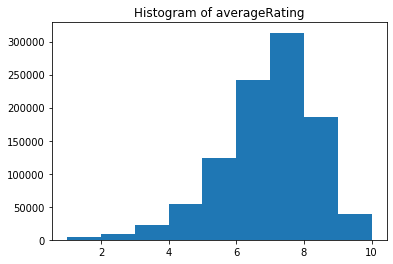

In [0]:
viz_histogram(df_ratings, 'averageRating', 9)

Our ratings range from **1** to **10**. The mean rating is **6.89** (maybe people are a little bit kinder than expected), with a standard deviation of roughly **1.40**. We have roughly **1 million** entries.

## How many votes does a movie have on average? (Box-Plot)

In [0]:
df_ratings.groupBy('tconst').mean('numVotes').describe().show()

+-------+---------+------------------+
summary| tconst| avg(numVotes)|
+-------+---------+------------------+
 count| 993821| 993821|
 mean| null| 955.4982275480193|
 stddev| null|15656.839581234844|
 min|tt0000001| 5.0|
 max|tt9916778| 2160364.0|
+-------+---------+------------------+

In [0]:
quantiles_votes = show_quantiles(df_ratings, ['numVotes'], percentiles)

+---------+---------+
Pecentile| numVotes|
+---------+---------+
 0.1| 5.0|
 0.25| 8.0|
 0.5| 19.0|
 0.75| 74.0|
 0.9|2160364.0|
+---------+---------+

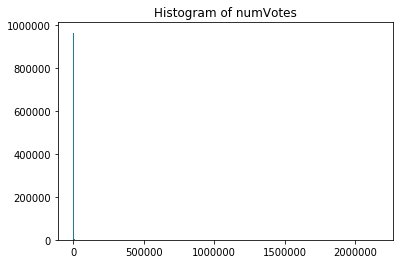

In [0]:
viz_histogram(df_ratings, 'numVotes', 1000)

# Names Table

In [0]:
df_sample = df_ratings.select('tconst').sample(False, 0.00003, 42)

In [0]:
df_principals.describe().show()

There are at most **10** people per mmovie listed, with an average of **4.62** and a std of **2.78**.

In [0]:
nulls_principals = get_nulls(df_principals)

In [0]:
nulls_principals

**83%** of values are missing for the `job` column and **49%** are missing for the `characters` column.

In [0]:
# df_principals.filter(col('tconst').isin(list_movies)).show()
df_principals.drop('job', 'characters')\
             .join(df_sample, on='tconst')\
             .groupBy('tconst').agg(_max('ordering'), countDistinct('category')).show()

In [0]:
from pyspark.sql.functions import 

df_principals.select(countDistinct('category')).show()

In [0]:
df_principals.groupBy("category").count().orderBy('count').show()

There are **12** distinct categories for job roles with **actor** being the highest ranked.

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

df_test = df_principals.sample(False, 0.0003, 42)

indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed = indexer.fit(df_test).transform(df_test)

encoder = OneHotEncoder(inputCol="categoryIndex",
                        outputCol="categoryOhe")
model = encoder.fit(indexed)
encoded = model.transform(indexed)
encoded.show()

In [0]:
.select('titleId', 'region', explode(array_distinct(split('region',','))).alias('regions')) \
  .groupBy('titleId', 'region').pivot('regions').count().fillna(0)

In [0]:
df_principals.filter(df_principals['tconst'] == 'tt0002076').show()

+---------+--------+---------+--------+--------+--------------------+
 tconst|ordering| nconst|category| job| characters|
+---------+--------+---------+--------+--------+--------------------+
tt0002076| 1|nm0169995| actor| \N|["The 1st Brother...|
tt0002076| 2|nm1189670| actor| \N|["The 2nd Brother...|
tt0002076| 3|nm0649925| actress| \N| ["The Mother"]|
tt0002076| 4|nm0290260| actress| \N| \N|
tt0002076| 5|nm0275941|director| \N| \N|
tt0002076| 6|nm0227843|producer|producer| \N|
tt0002076| 7|nm0916376| actor| \N|["An Elderly Prie...|
tt0002076| 8|nm0717468| actor| \N|["Undetermined Se...|
+---------+--------+---------+--------+--------+--------------------+

In [0]:
df_principals.select('tconst', 'category').groupBy('tconst').pivot('category').count().fillna(0).show()

+---------+-----+-------+---------------+-------------+---------------+--------+--------+------+--------+-------------------+----+------+
 tconst|actor|actress|archive_footage|archive_sound|cinematographer|composer|director|editor|producer|production_designer|self|writer|
+---------+-----+-------+---------------+-------------+---------------+--------+--------+------+--------+-------------------+----+------+
tt0011852| 3| 2| 0| 0| 1| 0| 1| 1| 0| 0| 0| 2|
tt0027610| 4| 1| 0| 0| 1| 0| 1| 1| 0| 0| 0| 2|
tt0032633| 1| 5| 0| 0| 1| 1| 1| 0| 0| 0| 0| 1|
tt0037657| 1| 1| 0| 0| 0| 1| 1| 0| 0| 0| 0| 1|
tt0041676| 2| 2| 0| 0| 0| 2| 1| 0| 0| 0| 0| 3|
tt0045736| 4| 0| 0| 0| 0| 1| 1| 1| 2| 0| 0| 0|
tt0047313| 2| 2| 0| 0| 0| 1| 1| 0| 2| 0| 0| 2|
tt0047525| 3| 1| 0| 0| 1| 1| 1| 1| 1| 0| 0| 0|
tt0052910| 2| 2| 0| 0| 2| 1| 1| 0| 1| 0| 0| 1|
tt0072927| 1| 3| 0| 0| 0| 1| 1| 0| 1| 0| 0| 3|
tt0076878| 2| 2| 0| 0| 0| 1| 1| 1| 0| 0| 0| 1|
tt0083191| 3| 2| 0| 0| 1| 1| 1| 0| 1| 0| 0| 1|
tt0088588| 2| 2| 0| 0| 0| 0| 1| 0| 1| 0| 0| 4|
tt0089680| 2| 2| 0| 0| 1| 1| 1| 1| 0| 0| 0| 1|
tt0098048| 2| 2| 0| 0| 1| 0| 1| 0| 1| 0| 0| 3|
tt0102216| 3| 1| 0| 0| 1| 1| 1| 0| 1| 1| 0| 1|
tt0104242| 2| 2| 0| 0| 0| 0| 1| 0| 3| 0| 0| 2|
tt0118251| 4| 1| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
tt0130223| 3| 1| 0| 0| 1| 1| 1| 1| 0| 1| 0| 1|
tt0154874| 1| 3| 0| 0| 0| 1| 1| 0| 1| 0| 0| 0|
+---------+-----+-------+---------------+-------------+---------------+--------+--------+------+--------+-------------------+----+------+
only showing top 20 rows

In [0]:
df_principals.where(df_principals['tconst'].isin(df_ratings['tconst']))

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2055372882343443> in <module> 
 ----> 1 df_principals . where ( df_principals [ 'tconst' ] . isin ( df_ratings [ 'tconst' ] ) ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in filter (self, condition) 
 1477 jdf = self . _jdf . filter ( condition ) 
 1478 elif isinstance ( condition , Column ) : 
 -> 1479 jdf = self . _jdf . filter ( condition . _jc ) 
 1480 else : 
 1481 raise TypeError ( "condition should be string or Column" ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : Resolved attribute(s) tconst#1530 missing from nconst#1504,tconst#1502,category#1505,job#1506,ordering#1503,characters#1507 in operator !Filter tconst#1502 IN (tconst#1530). Attribute(s) with the same name appear in the operation: tconst. Please check if the right attribute(s) are used.;;
!Filter tconst#1502 IN (tconst#1530)
+- Relation[tconst#1502,ordering#1503,nconst#1504,category#1505,job#1506,characters#1507] csv

In [0]:
df_principals.count()

Out[40]: 36499704

In [0]:
df_a = df_ratings.join(df_principals, on='tconst').groupBy('tconst', 'averageRating', 'numVotes')\
      .agg(_max('ordering').alias('principal_counts'), countDistinct('category').alias('distinct_count_categories'))

df_b = df_ratings.join(df_principals, on='tconst').select('tconst', 'category').groupBy('tconst').pivot('category').count().fillna(0)

df_a.join(df_b, on='tconst').printSchema()

root
-- tconst: string (nullable = true)
-- averageRating: double (nullable = true)
-- numVotes: integer (nullable = true)
-- principal_counts: integer (nullable = true)
-- distinct_count_categories: long (nullable = false)
-- actor: long (nullable = true)
-- actress: long (nullable = true)
-- archive_footage: long (nullable = true)
-- archive_sound: long (nullable = true)
-- cinematographer: long (nullable = true)
-- composer: long (nullable = true)
-- director: long (nullable = true)
-- editor: long (nullable = true)
-- producer: long (nullable = true)
-- production_designer: long (nullable = true)
-- self: long (nullable = true)
-- writer: long (nullable = true)

In [0]:
df_ratings.join(df_principals, on='tconst').select('tconst', 'category').groupBy('tconst').pivot('category').count().fillna(0).printSchema()

root
-- tconst: string (nullable = true)
-- actor: long (nullable = true)
-- actress: long (nullable = true)
-- archive_footage: long (nullable = true)
-- archive_sound: long (nullable = true)
-- cinematographer: long (nullable = true)
-- composer: long (nullable = true)
-- director: long (nullable = true)
-- editor: long (nullable = true)
-- producer: long (nullable = true)
-- production_designer: long (nullable = true)
-- self: long (nullable = true)
-- writer: long (nullable = true)

In [0]:
def principals(dataframe):
  df_a = dataframe.join(df_principals, on='tconst')\
      .groupBy('tconst', 'averageRating', 'numVotes')\
      .agg(_max('ordering').alias('principal_counts'), countDistinct('category').alias('distinct_count_categories'))
  
  df_b = dataframe.join(df_principals, on='tconst').select('tconst', 'category').groupBy('tconst').pivot('category').count().fillna(0)
  
  df_ids = df_a.join(df_b, on='tconst')
  
  return df_ids

df_train = principals(df_ratings)
df_train.printSchema()

root
-- tconst: string (nullable = true)
-- averageRating: double (nullable = true)
-- numVotes: integer (nullable = true)
-- principal_counts: integer (nullable = true)
-- distinct_count_categories: long (nullable = false)
-- actor: long (nullable = true)
-- actress: long (nullable = true)
-- archive_footage: long (nullable = true)
-- archive_sound: long (nullable = true)
-- cinematographer: long (nullable = true)
-- composer: long (nullable = true)
-- director: long (nullable = true)
-- editor: long (nullable = true)
-- producer: long (nullable = true)
-- production_designer: long (nullable = true)
-- self: long (nullable = true)
-- writer: long (nullable = true)

In [0]:
df_test.filter(df_test['category'] == 'self').show()

In [0]:
df_principals.sample(0.0003, 42).select('tconst', 'category').filter(df_principals['tconst'] == 'tt0002159').show()

In [0]:
import pyspark.sql.functions as F
df_test = df_principals.sample(0.0003)
categ = df_test.select('category').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [F.when(F.col('category') == cat,1).otherwise(0)\
            .alias(str(cat)) for cat in categ]

In [0]:
df = df_test.select(exprs+['tconst'])
display(df)

In [0]:
df = df_test.select(exprs+['tconst']).groupby('tconst').sum()
display(df)

In [0]:
encoded.groupBy('tconst').pivot('tconst', values=['category']).agg(_lit(1)).show()

In [0]:
df_names.show()